# Maximum global frequency by mutational effect

Determine how well mutational effect on non-terminal branches can predict the maximum frequency achieved by any clade sampled since the Perth 2009 DMS strain.

## Imports

In [1]:
%matplotlib inline
import os
import re
import Bio
import Bio.Phylo
import pickle
import gzip
import io
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import random
import pandas as pd
import scipy
from scipy.stats import spearmanr

# Use simple plot style with figures sized for context of a talk.
sns.set_style("ticks")
#sns.set_context("talk")

# Turn off spines for all plots.
plt.rc("axes.spines", top=False, right=False)

resultsdir = './results/'
inputdir = './data'
prefsdir = os.path.join(resultsdir, 'preferences/')
plotsdir = os.path.join(resultsdir, 'plots/')

## Configuration

In [158]:
frequency_bins = [0, 0.02, 0.10, 0.5, 0.99, 1]

cmap = plt.get_cmap("tab10")
global_colors = [cmap(0), cmap(1), cmap(2), cmap(3)]

color_per_label = {
    "pre-Perth": global_colors[0],
    "post-Perth": global_colors[1],
    "perth": (0.8, 0.8, 0.8, 1)
}

precision = 4
permutations = 10 ** precision

params = {
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [3.5, 3.5],
    'savefig.dpi': 120,
    'figure.dpi': 120
}
mpl.rcParams.update(params)

## Functions

In [62]:
def json_to_tree(json_dict):
    """Returns a Bio.Phylo tree corresponding to the given JSON dictionary exported
    by `tree_to_json`.
    >>> import json
    >>> json_fh = open("tests/data/flu_h3n2_ha_3y_tree.json", "r")
    >>> json_dict = json.load(json_fh)
    >>> tree = json_to_tree(json_dict)
    >>> tree.name
    u'NODE_0002020'
    >>> len(tree.clades)
    2
    >>> tree.clades[0].name
    u'NODE_0001489'
    >>> hasattr(tree, "attr")
    True
    >>> "dTiter" in tree.attr
    True
    """
    node = Bio.Phylo.Newick.Clade()
    node.name = json_dict["strain"]

    if "children" in json_dict:
        # Recursively add children to the current node.
        node.clades = [json_to_tree(child) for child in json_dict["children"]]
    else:
        node.clades = []

    # Assign all non-children attributes.
    for attr, value in json_dict.items():
        if attr != "children":
            setattr(node, attr, value)

    if "aa_sequence" in json_dict["attr"]:
        node.aa_sequence = json_dict["attr"]["aa_sequence"]
    
    return node

# Biopython's trees don't store links to node parents, so we need to build
# a map of each node to its parent.
# Code from the Bio.Phylo cookbook: http://biopython.org/wiki/Phylo_cookbook
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order='level'):
        for child in clade:
            parents[child] = clade
    return parents

def has_stop_codon(node):
    return "X" in node.aa_sequence or ("*" in node.aa_sequence and not node.aa_sequence.endswith("*"))

def calc_mutational_effect_for_tree(tree, stacked_preferences, gene_start_coordinates, perth_strain,
                                    positions=None, attr="mut_effect"):
    """
    """
    # Use all positions in the given sequence by default.
    default_preference = 1e-4
    aa_length = 566
    if positions is None:
        positions = list(range(aa_length))

    for node in tree.find_clades():
        mut_effect = 0
        total_mutations = 0

        if hasattr(node, "aa_muts"):
            for gene, muts in node.aa_muts.items():
                for mut in muts:
                    # Identify the original and mutation amino acids.
                    a1 = mut[0]
                    a2 = mut[-1]
                    
                    # Calculate absolute position of mutation in HA coordinates.
                    # Mutation coordinates from `aa_muts` are 1-based, while DMS
                    # preferences are zero-based.
                    r = int(mut[1:-1]) - 1 + gene_start_coordinates[gene]

                    # Calculate mutational effect if the mutation does not involve
                    # an unknown amino acid or stop codon.
                    if not r in positions and len(positions) == aa_length:
                        print("WARNING: Couldn't find position %i in all sites" % r)
                        
                    if "X" not in mut and "*" not in mut and r in positions:
                        mut_effect += np.log2(
                            stacked_preferences.get((r, a2), default_preference) / 
                            stacked_preferences.get((r, a1), default_preference)
                        )
                        total_mutations += 1
                        
        setattr(node, attr, mut_effect)
        node.attr[attr] = mut_effect
        node.attr["%s_mutations" % attr] = total_mutations

# Collect sequence preference, date, and trunk status for each
# node prior to the MRCA of all recent nodes.
def build_frame_for_nodes(nodes):
    nodes_df = []
    for node in nodes:
        node_values = {
            "mut_effect": node.attr["mut_effect"],
            "wsn_mut_effect": node.attr["wsn_mut_effect"],
            "date": node.attr["num_date"],
            "trunk": node.is_trunk,
            "terminal": node.is_terminal(),
            "name": node.name,
            "clade_id": node.clade,
            "max_frequency": node.attr["max_frequency"],
            "tips": node.tips,
            "total_mutations": node.attr["mut_effect_mutations"]
        }

        nodes_df.append(node_values)
            
    nodes_df = pd.DataFrame(nodes_df)

    return nodes_df

def spearman_permutation_test(x, y, permutations=100):
    """Returns a Spearman's rho for the given arrays, x and y, and
    a p-value corresponding to the proportion of permutations for
    which the rho between permuted data is greater than or equal to
    the observed rho.
    """
    rho, pvalue = spearmanr(x, y)
    successes = 0
    
    for i in range(permutations):
        y_permuted = np.random.permutation(y)
        permuted_rho, permuted_pvalue = spearmanr(x, y_permuted)
        
        if permuted_rho >= rho:
            successes += 1
    
    return rho, (successes / float(permutations))

## Load frequencies and tree JSONs

In [40]:
# Load frequencies JSON file used by auspice. These data are compressed.
# Decompress JSON data and load into a Python dict.
with gzip.open("./data/flu_h3n2_ha_1968_2018_6v_frequencies.json.gz", "rb") as json_uncompressed_fh:
    frequencies = json.load(json_uncompressed_fh)

In [41]:
pivots = np.array(frequencies["pivots"])

In [9]:
global_frequencies = {int(key.split(":")[-1]): np.array(values) for key, values in frequencies.items()
                      if key.startswith("global_clade:")}

In [11]:
# Load tree JSON file used by auspice. These data are compressed.
# Decompress JSON data and load into a Python dict.
with gzip.open("./data/flu_h3n2_ha_1968_2018_6v_tree.json.gz", "rb") as json_uncompressed_fh:
    json_tree = json.load(json_uncompressed_fh)

In [12]:
# Convert JSON tree layout to a Biopython Clade instance.
tree = json_to_tree(json_tree)

In [13]:
# Find the maximum frequency for each node in the tree.
max_frequency_by_node = {}
for node in tree.find_clades():
    max_frequency_by_node[node.clade] = global_frequencies[node.clade].max()

## Assign trunk status and relationship to Perth

Identify trunk and side branch nodes, find the Perth DMS strain, and find all pre- and post-Perth strains.

In [14]:
# Find the DMS strain.
dms_strain = [node for node in tree.find_clades() if node.strain == "A/Perth/16/2009"][0]

In [15]:
# Next, annotate each node with its parent.
parents_by_node = all_parents(tree)
for node in tree.find_clades():
    if node == tree.root:
        node.parent = None
    else:
        node.parent = parents_by_node[node]

In [16]:
# Find all tips of the tree sampled since 2017.
recent_nodes = [node for node in tree.get_terminals() if node.attr["num_date"] > 2017.83]

In [17]:
# Find the last common ancestor of all recent nodes.
mrca = tree.common_ancestor(recent_nodes)

In [18]:
# Define nodes that are unresolved in the most recent lineages.
unresolved_nodes = list(mrca.find_clades())

In [19]:
for node in tree.find_clades():
    node.is_trunk = False

In [20]:
# Find all nodes that are ancestral to recent nodes.
# Label these ancestral nodes as part of the "trunk"
# and collect the set of distinct nodes in the trunk.
for recent_node in recent_nodes:
    current_node = recent_node.parent
    
    # Traverse from the current node to the tree's root.
    while current_node != tree.root:
        # Mark a node as part of the trunk if it was sampled
        # before the MRCA of all recent nodes.
        if current_node.attr["num_date"] < mrca.attr["num_date"]:
            current_node.is_trunk = True
            
        current_node = current_node.parent

In [21]:
# Find the MRCA of any recent node and the Perth strain.
perth_mrca = tree.common_ancestor([recent_nodes[0], dms_strain])

# Prune all nodes in the corresponding child clades of that MRCA containing Perth.
perth_mrca_trunk = [clade for clade in perth_mrca.clades if clade.is_trunk][0]

# Find Perth strain's non-trunk ancestor.
perth_ancestor = [clade for clade in perth_mrca.clades if not clade.is_trunk][0]

In [22]:
for node in perth_ancestor.get_terminals():
    if node == dms_strain:
        print("Found Perth")

Found Perth


In [23]:
perth_mrca_trunk

Clade(aa_sequence='MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTNATE...', clade=2335, is_trunk=True, name='NODE_0002629', strain='NODE_0002629', tvalue=40.08531, xvalue=0.17585, yvalue=895.12948)

In [24]:
perth_mrca_trunk.attr["num_date"]

2007.9975439299244

In [25]:
# Confirm that the Perth MRCA's next trunk node has a frequency approaching 1.
np.around(global_frequencies[perth_mrca_trunk.clade], 3)[-10:]

array([ 1.   ,  0.998,  0.998,  0.998,  0.998,  0.998,  0.998,  0.997,
        0.996,  0.995])

In [33]:
perth_ancestor_ids = [node.clade for node in perth_ancestor.find_clades()]
post_perth_ids = [node.clade for node in perth_mrca_trunk.find_clades()]

### Count tips below each clade

In [27]:
for node in tree.find_clades(order="postorder"):
    tips = 0
    for clade in node.clades:
        if clade.is_terminal():
            tips += 1
        else:
            tips += clade.tips
        
    node.tips = tips

In [28]:
len([node.tips for node in tree.find_clades() if node.tips == 0])

2189

In [29]:
len(tree.get_terminals())

2189

## Visualize the tree

In [30]:
tree_to_plot = tree

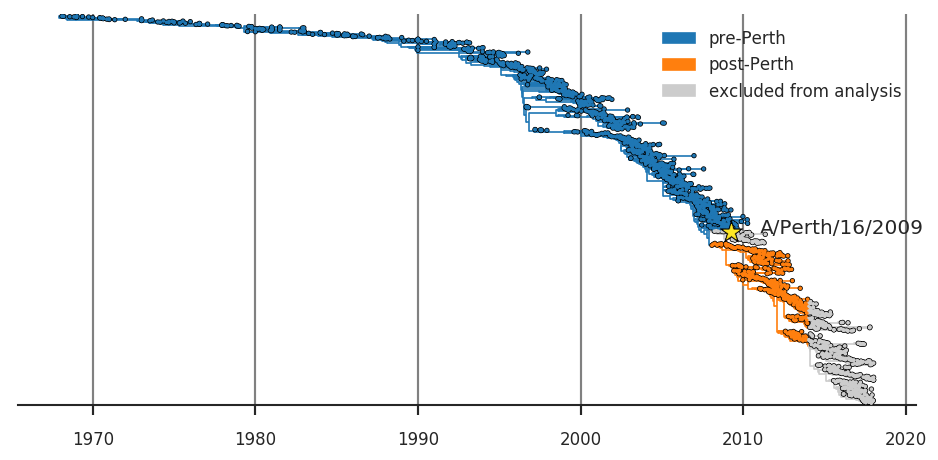

In [58]:
# Plot H3N2 tree in BALTIC style from Bio.Phylo tree.

#mpl.rcParams['font.weight']=300
#mpl.rcParams['axes.labelweight']=300
#mpl.rcParams['font.size']=22

yvalues = [node.yvalue for node in tree_to_plot.find_clades()]
y_span = max(yvalues)
y_unit = y_span / float(len(yvalues))

#
# Setup the figure grid.
#

fig, ax = plt.subplots(1, 1, figsize=(8, 4), facecolor='w')

L=len([k for k in tree_to_plot.find_clades() if k.is_terminal()])

# Setup arrays for tip and internal node coordinates.
tip_circles_x = []
tip_circles_y = []
tip_circles_color = []
tip_circle_sizes = []
node_circles_x = []
node_circles_y = []
node_circles_color = []
node_line_widths = []
node_line_segments = []
node_line_colors = []
branch_line_segments = []
branch_line_widths = []
branch_line_colors = []
branch_line_labels = []

for k in tree_to_plot.find_clades(): ## iterate over objects in tree
    x=k.attr["num_date"] ## or from x position determined earlier
    y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else
    
    if k.parent is None:
        xp = None
    else:
        xp=k.parent.attr["num_date"] ## get x position of current object's parent

    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if k.clade in perth_ancestor_ids or k.attr["num_date"] >= 2014.0:
        c = color_per_label["perth"]
    elif k.clade in post_perth_ids:
        c = color_per_label["post-Perth"]
    else:
        c = color_per_label["pre-Perth"]
    
    branchWidth=1
    if k.is_terminal(): ## if leaf...
        s=5 ## tip size can be fixed

        tip_circle_sizes.append(s)
        tip_circles_x.append(x)
        tip_circles_y.append(y)
        tip_circles_color.append(c)
    else: ## if node...
        k_leaves = [child
                    for child in k.find_clades()
                    if child.is_terminal()]
        
        # Instead of scaling branch widths by the number of tips
        # in each clade, scale by the predicted frequency.
        #branchWidth += 15.0 * predicted_freq_by_clade.get(k.clade, 0.0)

        if len(k.clades)==1:
            node_circles_x.append(x)
            node_circles_y.append(y)
            node_circles_color.append(c)

        ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')
    
    branch_line_segments.append([(xp, y), (x, y)])
    branch_line_widths.append(branchWidth)
    branch_line_colors.append(c)

branch_lc = LineCollection(branch_line_segments, zorder=9)
branch_lc.set_color(branch_line_colors)
branch_lc.set_linewidth(branch_line_widths)
branch_lc.set_label(branch_line_labels)
branch_lc.set_linestyle("-")
ax.add_collection(branch_lc)
    
# Add circles for tips and internal nodes.
tip_circle_sizes = np.array(tip_circle_sizes)
ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

# Call out the DMS strain with a bordered star.
star_size = 100
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size, facecolor=["#fde725"], zorder=20)
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size * 2, facecolor=["#000000"], zorder=19)

# Annotate the DMS strain name.
ax.text(dms_strain.attr["num_date"] + 1.75, dms_strain.yvalue - 8, dms_strain.strain)

ax.set_ylim(-10, y_span + 10)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])

# Add legend for colors.
patches = []
for key in ["pre-Perth", "post-Perth", "perth"]:
    if key == "perth":
        label = "excluded from analysis"
    else:
        label = key
        
    patches.append(mpatches.Patch(color=color_per_label[key], label=label))
    
ax.legend(handles=patches)

plt.tight_layout()
plt.savefig("./results/plots/flu-h3n2-ha-1968-2018-tree.pdf")

## Calculate mutational effects with Perth/2009 preferences

For each node in the tree, use the amino acid mutations to calculate mutational effects on each branch.

In [45]:
# Define start positions in amino acids for HA genes including SigPep, HA1, and HA2.
# These positions will be used to calculate the absolute position in HA for amino acid
# mutations annotated in gene-specific coordinates.
gene_start_coordinates = {
    "SigPep": 0,
    "HA1": 16,
    "HA2": 345
}

In [46]:
# Load DMS preferences.
preferences_file = "./results/H3renumberedprefs/summary_avgprefs_rescaled.csv"
preferences = pd.read_csv(preferences_file)
preferences.index.name = "HA_position"
preferences = preferences.reset_index()

In [47]:
# Stack preferences for all amino acids to enable indexing preferences
# by site and amino acid with tuples.
stacked_preferences = preferences.loc[:, "A":"Y"].stack()

In [48]:
calc_mutational_effect_for_tree(tree, stacked_preferences, gene_start_coordinates, dms_strain)

In [49]:
for node in tree.find_clades():
    node.attr["max_frequency"] = max_frequency_by_node[node.clade]

Text(0,0.5,'Number of nodes')

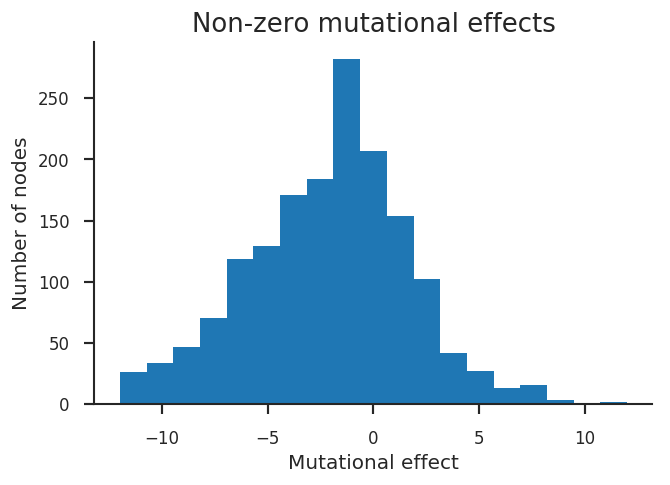

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
key = "mut_effect"
bins = np.linspace(-12, 12, 20)

ax.hist([node.attr[key] for node in tree.find_clades() if node.attr[key] != 0], bins=bins)
ax.set_title("Non-zero mutational effects")
ax.set_xlabel("Mutational effect")
ax.set_ylabel("Number of nodes")

## Calculate mutational effects by maximum frequency with WSN preferences

WSN preferences have already been converted to H3 numbering.

In [50]:
# Load DMS preferences.
wsn_preferences_file = "./data/WSN_avgprefs_rescaled_seqnumbering.csv"
wsn_preferences = pd.read_csv(wsn_preferences_file, index_col=0)
wsn_preferences.index.name = "HA_position"

In [53]:
# Stack preferences for all amino acids to enable indexing preferences
# by site and amino acid with tuples.
wsn_stacked_preferences = wsn_preferences.loc[:, "A":"Y"].stack()

In [54]:
wsn_stacked_preferences.head()

HA_position   
2            A    0.004310
             C    0.139045
             D    0.005275
             E    0.008596
             F    0.021876
dtype: float64

In [55]:
calc_mutational_effect_for_tree(tree, wsn_stacked_preferences, gene_start_coordinates, dms_strain,
                                attr="wsn_mut_effect")

## Maximum frequency by mutational effect for pre- and post-Perth nodes

To get a sense of how well mutational effect predicts success of nodes sampled after the Perth DMS strain, we look at the maximum frequency achieved by both pre- and post-Perth node by mutational effect across different site masks.

Nodes inside the Perth side branch clade are omitted from the analysis. Nodes occuring after 2014 are also omitted to avoid including recent low frequency variants that have not had time to resolve as fixed in the population.

In [67]:
df = build_frame_for_nodes(list(tree.find_clades()))

In [68]:
# Bin events by maximum frequency.
df["max_frequency_bins"] = pd.cut(df["max_frequency"], bins=frequency_bins)

In [69]:
def annotate_perth_status(clade_id):
    if clade_id in perth_ancestor_ids:
        return "perth_clade"
    elif clade_id in post_perth_ids:
        return "post-Perth"
    else:
        return "pre-Perth"

df["perth_status"] = df["clade_id"].apply(annotate_perth_status)

In [70]:
# Omit nodes sampled from 2014 onward.
df = df[df["date"] < 2014.0].copy()

In [71]:
# Omit nodes occuring inside the Perth clade.
df = df[df["perth_status"] != "perth_clade"].copy()

In [72]:
# Keep only nodes with non-zero mutational effects.
df = df[df["mut_effect"] != 0].copy()

In [73]:
df.shape

(1321, 12)

In [74]:
df.head()

,clade_id,date,max_frequency,mut_effect,name,terminal,tips,total_mutations,trunk,wsn_mut_effect,max_frequency_bins,perth_status
6,6,1968.413639,0.454441,-0.903412,NODE_0002175,False,13,1,False,0.606021,"(0.1, 0.5]",pre-Perth
7,7,1969.364369,0.034957,-4.426097,A/Bilthoven/808/1969,True,0,5,False,14.921013,"(0.02, 0.1]",pre-Perth
9,9,1968.846194,0.034957,-11.362345,A/Aichi/2/1968,True,0,2,False,1.178821,"(0.02, 0.1]",pre-Perth
10,10,1969.747027,0.034957,-1.024112,A/HongKong/3/1969,True,0,3,False,6.818039,"(0.02, 0.1]",pre-Perth
11,11,1968.688786,0.314613,3.551956,NODE_0002179,False,9,2,False,-5.017738,"(0.1, 0.5]",pre-Perth


In [75]:
df["date"].max()

2013.9856262833675

In [76]:
df["max_frequency_bins"].value_counts()

(0.0, 0.02]    769
(0.02, 0.1]    264
(0.99, 1.0]     77
(0.1, 0.5]      73
(0.5, 0.99]     15
Name: max_frequency_bins, dtype: int64

In [197]:
df["perth_status"].value_counts()

pre-Perth     1022
post-Perth     299
Name: perth_status, dtype: int64

### Distributions of maximum frequency by Perth/2009 mutational effect

pre-Perth: 0.0
post-Perth: 0.0081


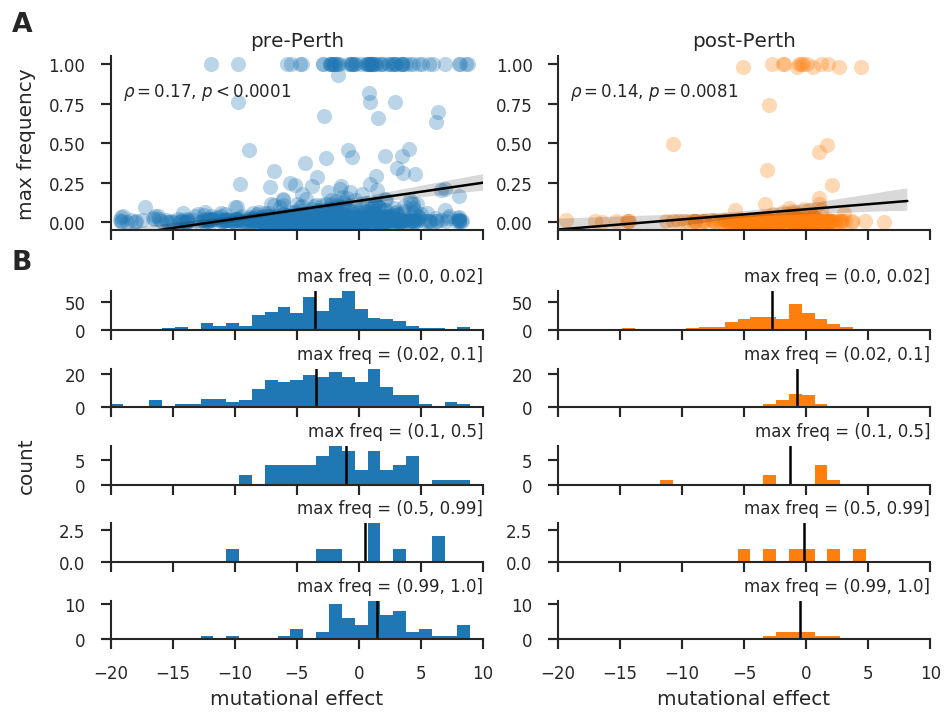

In [198]:
#
# Perth preferences.
#

fig = plt.figure(figsize=(8, 6))
gs0 = gridspec.GridSpec(2, 1, height_ratios=[1, 2], hspace=1.0)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
gs01 = gridspec.GridSpecFromSubplotSpec(len(frequency_bins) - 1, 2, subplot_spec=gs0[1], hspace=1.0)

permutations = 10000
large_fontsize = 12
fontsize = 10

#
# Scatterplot
#

grouped_df = df.groupby("perth_status")
color_per_label = {
    "pre-Perth": global_colors[0],
    "post-Perth": global_colors[1]
}

for i, group in enumerate(("pre-Perth", "post-Perth")):
    ax = plt.subplot(gs00[0, i], )
    group_df = grouped_df.get_group(group)
    rho, permutation_pvalue = spearman_permutation_test(
        group_df["max_frequency"],
        group_df["mut_effect"],
        permutations=permutations
    )
    print("%s: %s" % (group, permutation_pvalue))
    
    if permutation_pvalue < 1.0 / permutations:
        permutation_pvalue = 1.0 / permutations
        sign = "<"
    else:
        sign = "="
    
    label = "$\\rho = %.2f$, $p %s %s$" % (rho, sign, round(permutation_pvalue, precision))
    sns.regplot("mut_effect", "max_frequency", group_df, ax=ax, scatter_kws={"alpha": 0.3},
                color=color_per_label[group], line_kws={"color": "black", "lw": 1.5})

    ax.text(-19, 0.8, label, fontsize=fontsize)
    ax.set_xlabel("")
    
    if i == 0:
        ax.set_ylabel("max frequency", fontdict={"fontsize": large_fontsize})
    else:
        ax.set_ylabel("")
        
    ax.set_title(group, fontsize=large_fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.get_yaxis().set_label_coords(-0.2, 0.5)
    ax.set_xlim(-20, 10)
    ax.set_ylim(-0.05, 1.05)
    
    ax.get_xaxis().set_ticklabels([])

#
# Histograms
#

key = "mut_effect"
data = df
grouped_data = data.groupby("max_frequency_bins")
num_groups = len(grouped_data.groups.keys())

for i, (frequency_bin, frequency_bin_df) in enumerate(grouped_data):
    for j, perth_clade in enumerate(("pre-Perth", "post-Perth")):
        ax = plt.subplot(gs01[i, j])
        perth_clade_df = frequency_bin_df[frequency_bin_df["perth_status"] == perth_clade]
        n, hist_bins, patches = ax.hist(perth_clade_df[key].values, bins=bins, color=color_per_label[perth_clade])
        ax.axvline(perth_clade_df[key].mean(), c="black", lw=1.5)

        ax.set_title("max freq = %s" % frequency_bin, {"fontsize": fontsize}, loc="right")
        ax.set_xlabel("mutational effect", fontdict={"fontsize": large_fontsize})
        ax.tick_params(labelsize=fontsize)
        
        if i == np.median(np.arange(0, len(frequency_bins) - 1)) and j == 0:
            ax.set_ylabel("count", fontdict={"fontsize": large_fontsize})
            ax.get_yaxis().set_label_coords(-0.2, 0.5)
        else:
            ax.set_ylabel("")
        
        ax.set_xlim(-20, 10)
        
        if j == 0:
            y_upper_limit = n.max()
            
        ax.set_ylim(0, y_upper_limit)
        
        if i != len(grouped_data) - 1:
            ax.get_xaxis().set_ticklabels([])
            ax.set_xlabel("")

# Annotate panel label.
fig.text(0.01, 0.98, "A", fontsize=16, weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.01, 0.65, "B", fontsize=16, weight="bold", horizontalalignment='left', verticalalignment='center')

gs0.tight_layout(fig, w_pad=1.0)
plt.savefig("./results/plots/max-frequency-by-mutational-effect-for-Perth-preferences.pdf")

### Distributions of maximum frequency by WSN mutational effect

pre-Perth: 0.938
post-Perth: 0.371


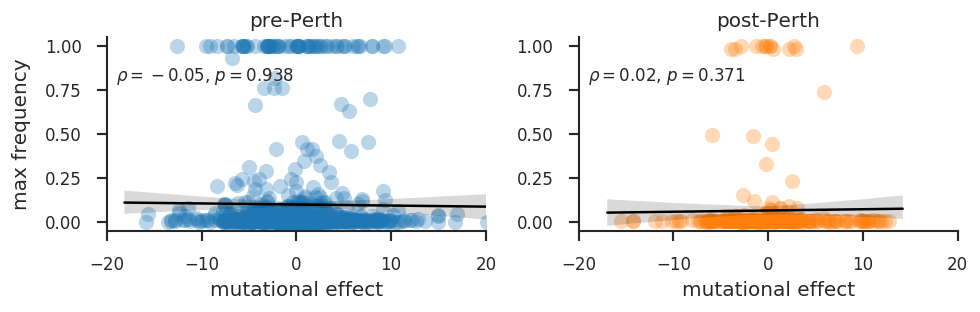

In [202]:
#
# WSN preferences
#

permutations = 1000

#
# Scatterplot
#

fig = plt.figure(figsize=(8, 2.5))
gs00 = gridspec.GridSpec(1, 2, bottom=0.3)

grouped_df = df.groupby("perth_status")
color_per_label = {
    "pre-Perth": global_colors[0],
    "post-Perth": global_colors[1]
}

for i, group in enumerate(("pre-Perth", "post-Perth")):
    ax = plt.subplot(gs00[0, i], )
    group_df = grouped_df.get_group(group)
    rho, permutation_pvalue = spearman_permutation_test(
        group_df["max_frequency"],
        group_df["wsn_mut_effect"],
        permutations=permutations
    )
    print("%s: %s" % (group, permutation_pvalue))
    
    if permutation_pvalue < 1.0 / permutations:
        permutation_pvalue = 1.0 / permutations
        sign = "<"
    else:
        sign = "="
    
    label = "$\\rho = %.2f$, $p %s %s$" % (rho, sign, round(permutation_pvalue, precision))
    sns.regplot("wsn_mut_effect", "max_frequency", group_df, ax=ax, scatter_kws={"alpha": 0.3},
                color=color_per_label[group], line_kws={"color": "black", "lw": 1.5})

    ax.text(-19, 0.8, label, fontsize=fontsize)
    ax.set_xlabel("mutational effect", fontdict={"fontsize": large_fontsize})
    
    if i == 0:
        ax.set_ylabel("max frequency", fontdict={"fontsize": large_fontsize})
    else:
        ax.set_ylabel("")
        
    ax.set_title(group, fontsize=large_fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.get_yaxis().set_label_coords(-0.2, 0.5)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0.05, 1.05)

gs00.tight_layout(fig, pad=0.3, h_pad=0.0, w_pad=1.0)
fig.savefig("./results/plots/max-frequency-by-mutational-effect-for-WSN-preferences-scatterplot.pdf")

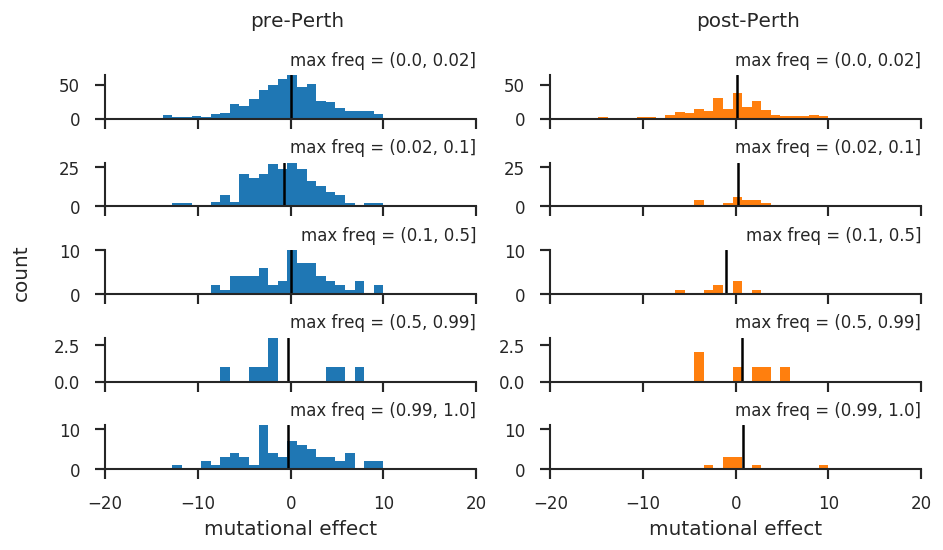

In [215]:
#
# Histograms
#

fig = plt.figure(figsize=(8, 4.5))
gs01 = gridspec.GridSpec(len(frequency_bins) - 1, 2, hspace=1.0)

key = "wsn_mut_effect"
data = df
grouped_data = data.groupby("max_frequency_bins")
num_groups = len(grouped_data.groups.keys())

for i, (frequency_bin, frequency_bin_df) in enumerate(grouped_data):
    for j, perth_clade in enumerate(("pre-Perth", "post-Perth")):
        ax = plt.subplot(gs01[i, j])
        perth_clade_df = frequency_bin_df[frequency_bin_df["perth_status"] == perth_clade]
        n, hist_bins, patches = ax.hist(perth_clade_df[key].values, bins=bins, color=color_per_label[perth_clade])
        ax.axvline(perth_clade_df[key].mean(), c="black", lw=1.5)

        ax.set_title("max freq = %s" % frequency_bin, {"fontsize": fontsize}, loc="right")
        ax.set_xlabel("mutational effect", fontdict={"fontsize": large_fontsize})
        ax.tick_params(labelsize=fontsize)
        
        if i == np.median(np.arange(0, len(frequency_bins) - 1)) and j == 0:
            ax.set_ylabel("count", fontdict={"fontsize": large_fontsize})
            ax.get_yaxis().set_label_coords(-0.2, 0.5)
        else:
            ax.set_ylabel("")
        
        ax.set_xlim(-20, 20)
        
        if j == 0:
            y_upper_limit = n.max()
            
        ax.set_ylim(0, y_upper_limit)
        
        if i != len(grouped_data) - 1:
            ax.get_xaxis().set_ticklabels([])
            ax.set_xlabel("")

fig.text(0.3, 0.98, "pre-Perth", fontsize=12, horizontalalignment='center', verticalalignment='center')
fig.text(0.77, 0.98, "post-Perth", fontsize=12, horizontalalignment='center', verticalalignment='center')

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
#gs01.tight_layout(fig, pad=0., h_pad=0.3, w_pad=1.0)
plt.savefig("./results/plots/max-frequency-by-mutational-effect-for-WSN-preferences-histograms.pdf")

## Inspect tip frequencies to determine lowest max frequency bin range

Text(0.5,1,'post-Perth')

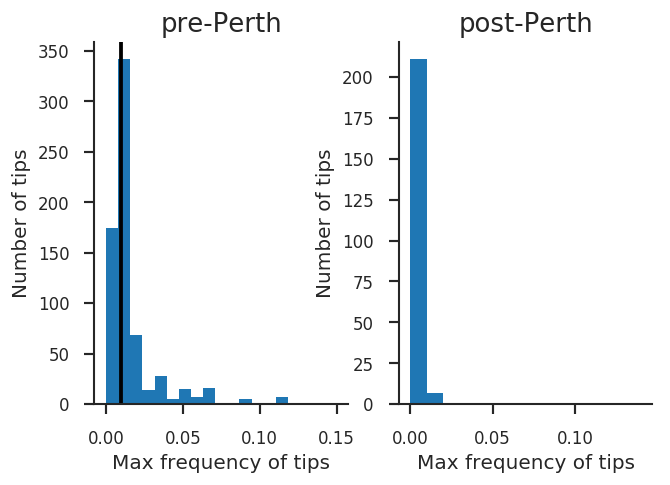

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

ax = axes[0]
data = df[(df["tips"] == 0) & (df["perth_status"] == "pre-Perth")]
ax.hist(data["max_frequency"], bins=np.linspace(0, 0.15, 20))
ax.axvline(0.01, color="black")
ax.set_xlabel("Max frequency of tips")
ax.set_ylabel("Number of tips")
ax.set_title("pre-Perth")

ax = axes[1]
data = df[(df["tips"] == 0) & (df["perth_status"] == "post-Perth")]
ax.hist(data["max_frequency"], bins=np.arange(0, 0.15, 0.01))
ax.set_xlabel("Max frequency of tips")
ax.set_ylabel("Number of tips")
ax.set_title("post-Perth")

## Demonstrate maximum clade frequency calculation

In [136]:
# Find trunk node sampled after the given date.
min_date = 2000.0
max_date = 2014.0

for node in tree.find_clades():
    if node.is_trunk and node.attr["num_date"] > min_date:
        tree_to_plot = node
        break

In [141]:
lab_colors = [
    "#fceabb",
    "#a2acae",
    "#36729e"
]
trait_name = 'mut_effect'
traits = [node.attr[trait_name] for node in tree_to_plot.find_clades() if node.attr[trait_name] != 0]

In [142]:
color_bins = [-np.inf, -10, 0, np.inf]
pd.cut(traits, bins=color_bins).value_counts()

(-inf, -10.0]     49
(-10.0, 0.0]     762
(0.0, inf]       290
dtype: int64

In [143]:
counts = pd.cut(traits, bins=color_bins).value_counts()
counts / counts.sum()

(-inf, -10.0]    0.044505
(-10.0, 0.0]     0.692098
(0.0, inf]       0.263397
dtype: float64

In [144]:
counts.sum()

1101

In [145]:
# Define bins for mutational effects.
traits_by_clade = [{"clade": node.clade, trait_name: node.attr[trait_name]}
                   for node in tree_to_plot.find_clades() if node.attr[trait_name] != 0]
traits_df = pd.DataFrame(traits_by_clade)

In [150]:
traits_df["bin"] = pd.cut(traits_df[trait_name], bins=color_bins)

In [151]:
# Map bin to color.
bin_to_color = dict(zip(traits_df["bin"].unique(), lab_colors))
traits_df["color"] = traits_df.apply(lambda row: bin_to_color[row["bin"]], axis=1)

In [152]:
traits_df.head()

,clade,mut_effect,bin,color
0,1190,-11.932143,"(-inf, -10.0]",#fceabb
1,1194,-2.719242,"(-10.0, 0.0]",#a2acae
2,1197,-0.658333,"(-10.0, 0.0]",#a2acae
3,1200,-7.817956,"(-10.0, 0.0]",#a2acae
4,1201,-0.631161,"(-10.0, 0.0]",#a2acae


In [153]:
# Map color to node.
color_by_clade = dict(traits_df.loc[:, ["clade", "color"]].values)

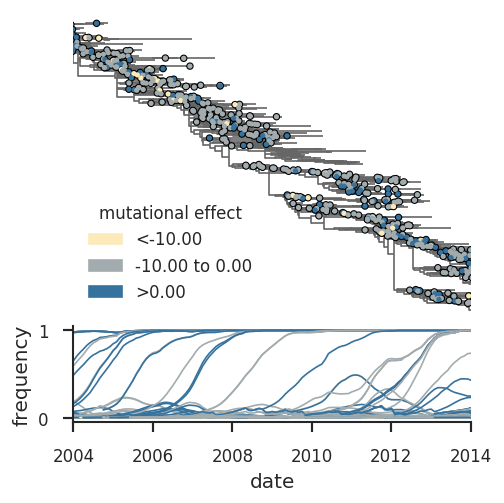

In [176]:
#
# Setup grid.
#

min_display_date = 2004
max_display_date = max_date
min_effect = 0.0

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(2, 1, hspace=0.0, height_ratios=[3.14, 1])

#
# Tree
#

ax = plt.subplot(gs[0])

yvalues = [node.yvalue for node in tree_to_plot.find_clades()]
y_span = max(yvalues)

trait_name = 'mut_effect'
traits = [node.attr[trait_name] for node in tree_to_plot.find_clades()]

#
# Setup the figure grid.
#

L=len([k for k in tree_to_plot.find_clades() if k.is_terminal()])

# Setup arrays for tip and internal node coordinates.
tip_circles_x = []
tip_circles_y = []
tip_circles_color = []
tip_circle_sizes = []

node_circles_x = []
node_circles_y = []
node_circles_color = []
node_line_widths = []
node_line_segments = []
node_line_colors = []

branch_line_segments = []
branch_line_widths = []
branch_line_colors = []
branch_line_labels = []
branch_color = "#666666"

mutation_circles_x = []
mutation_circles_y = []
mutation_circles_color = []
mutation_circle_sizes = []

for k in tree_to_plot.find_clades(): ## iterate over objects in tree
    x=k.attr["num_date"] ## or from x position determined earlier
    y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else
    
    if k.parent is None:
        xp = None
    else:
        xp=k.parent.attr["num_date"] ## get x position of current object's parent

    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    c = (0.4, 0.4, 0.4, 1.0)
    mut_c = "#ffffff"
    if trait_name in k.attr and np.abs(k.attr[trait_name]) > min_effect:
        mut_c = color_by_clade[k.clade]
            
    branchWidth=1
    if k.is_terminal(): ## if leaf...
        s=6 ## tip size can be fixed
        mut_s = 10
        tip_circle_sizes.append(s)
        tip_circles_x.append(x)
        tip_circles_y.append(y)
        tip_circles_color.append(c)
        
        if k.clade not in perth_ancestor_ids and xp is not None and np.abs(k.attr[trait_name]) > min_effect:
            mutation_circle_sizes.append(mut_s)
            mutation_circles_x.append(xp + ((x - xp) / 2.0))
            mutation_circles_y.append(y)
            mutation_circles_color.append(mut_c)
    else: ## if node...
        k_leaves = [child
                    for child in k.find_clades()
                    if child.is_terminal()]
        
        # Instead of scaling branch widths by the number of tips
        # in each clade, scale by the predicted frequency.
        #branchWidth += 15.0 * predicted_freq_by_clade.get(k.clade, 0.0)

        if len(k.clades)==1:
            node_circles_x.append(x)
            node_circles_y.append(y)
            node_circles_color.append(c)

        ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=branch_color, ls='-', zorder=9, solid_capstyle='round')
    
    branch_line_segments.append([(xp, y), (x, y)])
    branch_line_widths.append(branchWidth)
    branch_line_colors.append(branch_color)

branch_lc = LineCollection(branch_line_segments, zorder=9)
branch_lc.set_color(branch_line_colors)
branch_lc.set_linewidth(branch_line_widths)
branch_lc.set_label(branch_line_labels)
branch_lc.set_linestyle("-")
ax.add_collection(branch_lc)
    
# Add circles for tips and internal nodes.
tip_circle_sizes = np.array(tip_circle_sizes)
#ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
#ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

# Add circles for mutations.
mutation_circle_sizes = np.array(mutation_circle_sizes)
ax.scatter(mutation_circles_x, mutation_circles_y, s=mutation_circle_sizes, facecolor=mutation_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
ax.scatter(mutation_circles_x, mutation_circles_y, s=mutation_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath

ax.set_xlim(min_display_date, max_display_date)
ax.set_ylim(300, 1500)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.grid(axis='x', ls='-', color='grey')
ax.tick_params(axis='y',size=0)
ax.tick_params(axis='x',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

patches = []

for interval, color in bin_to_color.items():
    if interval.left == -np.inf:
        label = "<%.2f" % interval.right
    elif interval.right == np.inf:
        label= ">%.2f" % interval.left
    else:
        label = "%.2f to %.2f" % (interval.left, interval.right)
        
    patches.append(mpatches.Patch(color=color, label=label))

legend = ax.legend(handles=patches, loc="lower left", title="mutational effect", fontsize=10)
legend.get_title().set_fontsize(10)

#
# Frequencies
#

ax = plt.subplot(gs[1])
lw = 1
max_abs_trait = max(np.abs(traits))

for node in tree_to_plot.find_clades():
    if node.clade not in perth_ancestor_ids and np.abs(node.attr[trait_name]) > min_effect:
        node_frequencies = global_frequencies[node.clade]
        x = pivots[node_frequencies.argmax()]
        y = node_frequencies.max()
        nonzero = np.nonzero(node_frequencies)
        clade_color = color_by_clade[node.clade]
        ax.plot(pivots[nonzero], node_frequencies[nonzero], lw=lw, c=clade_color)

        ax.set_xlim(min_display_date, max_display_date)
        ax.set_xlabel("date")
        ax.set_ylabel("frequency")
        ax.label_outer()

gs.tight_layout(fig, pad=0.0)
plt.savefig("./results/plots/phylogeny-and-frequency-of-mutational-effects.pdf")